# SIMULACIÓN PV Y ANALISIS DE SENSIBILIDAD

NOTA:
    Para observar todos los gráficos a la ves, visite http://127.0.0.1:8050/

In [20]:
import PySAM.Pvwattsv7 as pv
import PySAM.Lcoefcr as Lcoefcr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os


 # Definición de funciones
 Función para Simulación Comparativa Energía Anual vs Capacidad

In [21]:

def simular_comparativa_energia_capacidad(paises, plantas, output_dir_graphs, output_dir_results):
    """
    Realiza simulaciones PV para diferentes países y capacidades de planta,
    y genera un gráfico comparativo.
    """
    print("\n--- Iniciando Simulación Comparativa Energía Anual vs Capacidad ---")
    resultados_simulacion = [] # Lista para guardar todos los resultados

    # Iterar sobre cada país para la simulación comparativa
    for pais_info in paises:
        pais_nombre = pais_info["nombre"]
        solar_resource_file = pais_info["archivo"]
        color_pais = pais_info["color"]

        # Determinar Azimut correcto para el país actual (para la comparativa)
        if pais_nombre in ["chile", "australia"]: # Hemisferio Sur
            azimuth_correcto = 0
        else: # Hemisferio Norte (España)
            azimuth_correcto = 180

        print(f"  Simulando para {pais_nombre.capitalize()} (Azimuth: {azimuth_correcto}°)...")

        for p in plantas:
            try:
                pv_model = pv.new()
                pv_model.SolarResource.solar_resource_file = solar_resource_file
                pv_model.SystemDesign.system_capacity = p["capacity_kw"]
                pv_model.SystemDesign.dc_ac_ratio = p["dc_ac_ratio"]
                pv_model.SystemDesign.array_type = 1
                pv_model.SystemDesign.azimuth = azimuth_correcto # Usar Azimut correcto
                pv_model.SystemDesign.tilt = p["tilt"]       # Tilt fijo (de la lista plantas) para la comparativa
                pv_model.SystemDesign.gcr = 0.4
                pv_model.SystemDesign.inv_eff = 96
                pv_model.SystemDesign.losses = 14.0
                pv_model.AdjustmentFactors.constant = 0 # Ajuste de pérdidas constantes

                # Ejecutar simulación
                pv_model.execute()

                # Obtener la energía anual [kWh]
                annual_energy = pv_model.Outputs.annual_energy

                # Guardar resultados en la lista general
                resultados_simulacion.append({
                    "pais": pais_nombre.capitalize(),
                    "capacidad_kw": p["capacity_kw"],
                    "energia_kwh": annual_energy,
                    "color": color_pais
                })
                # print(f"    - {p['nombre']}: {annual_energy:.2f} kWh") # Opcional: muy verboso

            except Exception as e:
                print(f"      Error simulando {p['nombre']} para {pais_nombre}: {e}")
                # Opcional: añadir marcador de error o saltar
                resultados_simulacion.append({
                    "pais": pais_nombre.capitalize(),
                    "capacidad_kw": p["capacity_kw"],
                    "energia_kwh": 0, # O np.nan
                    "color": color_pais
                })
    print("------------Gráfico de comparación de energía anual vs capacidad------------")
    # Crear un único gráfico de dispersión/línea con todos los resultados
    if resultados_simulacion:
        plt.figure(figsize=(10, 6))

        # Agrupar por país para asignar colores y leyendas
        paises_unicos = sorted(list(set(res["pais"] for res in resultados_simulacion))) # Ordenar países
        for pais in paises_unicos:
            # Filtrar datos para el país actual
            datos_pais = [res for res in resultados_simulacion if res["pais"] == pais]
            # Ordenar por capacidad para que la línea se dibuje correctamente
            datos_pais.sort(key=lambda x: x["capacidad_kw"])

            capacidades = [res["capacidad_kw"] for res in datos_pais]
            energias = [res["energia_kwh"] for res in datos_pais]
            color = datos_pais[0]["color"] # Obtener color del primer resultado

            plt.plot(capacidades, energias, label=pais, color=color, marker='o', linestyle='-', linewidth=2, markersize=6)

        plt.xlabel("Capacidad de Planta (kW)")
        plt.ylabel("Energía Anual Generada (kWh)")
        plt.title("Energía Anual vs Capacidad de Planta por País")
        plt.legend(title="País")
        plt.grid(True, linestyle='--')
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0)) # Notación científica
        plt.tight_layout()

        # Guardar el gráfico
        output_filename = "pv_energia_vs_capacidad_all_countries.png"
        output_filepath = os.path.join(output_dir_graphs, output_filename) # Usa output_dir_graphs
        plt.savefig(output_filepath)
        plt.show()
        plt.close()
        print(f"\nGráfico comparativo Energía vs Capacidad guardado en: {output_filepath}")
        
        # --- INICIO CÓDIGO PARA GUARDAR CSV ---
        df_resultados = pd.DataFrame(resultados_simulacion)
        df_resultados = df_resultados[df_resultados['energia_kwh'] > 0] # Filtrar errores

        if not df_resultados.empty:
            output_csv_filename = "resultados_pv_energia_vs_capacidad.csv"
            # Usa output_dir_results para la ruta del CSV
            output_filepath_csv = os.path.join(output_dir_results, output_csv_filename) # <-- Nuevo nombre para CSV
            try:
                df_resultados_save = df_resultados.drop(columns=['color'], errors='ignore')
                df_resultados_save.to_csv(output_filepath_csv, index=False, float_format='%.2f')
                print(f"Resultados numéricos Energía vs Capacidad guardados en: {output_filepath_csv}") # <-- Nuevo nombre para CSV
            except Exception as e:
                print(f"Error al guardar resultados numéricos Energía vs Capacidad: {e}")
        else:
             print("\nNo se generaron resultados válidos para guardar en CSV de Energía vs Capacidad.")
        # --- FIN CÓDIGO PARA GUARDAR CSV ---
    else:
        print("\nNo se generaron resultados para el gráfico Energía vs Capacidad.")

Función para Análisis de Sensibilidad de Inclinación (Tilt)

In [35]:
def analizar_sensibilidad_inclinacion(paises, output_dir_graphs, output_dir_results, config):
    """
    Realiza un análisis de sensibilidad variando la inclinación de los paneles
    para una configuración de planta fija en diferentes países.
    """
    print("\n--- Iniciando Análisis de Sensibilidad de Inclinación ---")

    # Parámetros fijos del diccionario de configuración
    sens_capacity_kw = config.get("capacity_kw", 1000.0)
    sens_dc_ac_ratio = config.get("dc_ac_ratio", 1.2)
    sens_gcr = config.get("gcr", 0.4)
    sens_inv_eff = config.get("inv_eff", 96)
    sens_losses = config.get("losses", 14.0)
    sens_adjust_constant = config.get("adjust_constant", 0)
    sens_array_type = config.get("array_type", 1)

    tilt_angles = np.arange(0, 91, 5) # Rango de inclinaciones
    tilt_sensitivity_results_all = [] # Lista para todos los resultados

    # Iterar sobre cada país
    for pais_info in paises:
        pais_nombre = pais_info["nombre"]
        sens_solar_resource_file = pais_info["archivo"]
        color_pais = pais_info["color"]

        # Determinar Azimut correcto para el país actual
        if pais_nombre in ["chile", "australia"]: # Hemisferio Sur
            sens_azimuth = 0
        else: # Hemisferio Norte (España)
            sens_azimuth = 180

        print(f"  Calculando sensibilidad de inclinación para {pais_nombre.capitalize()} (Azimuth: {sens_azimuth}°)...")

        for tilt in tilt_angles:
            try:
                pv_sens_model = pv.new()
                pv_sens_model.SolarResource.solar_resource_file = sens_solar_resource_file
                pv_sens_model.SystemDesign.system_capacity = sens_capacity_kw
                pv_sens_model.SystemDesign.dc_ac_ratio = sens_dc_ac_ratio
                pv_sens_model.SystemDesign.array_type = sens_array_type
                pv_sens_model.SystemDesign.azimuth = sens_azimuth
                pv_sens_model.SystemDesign.tilt = float(tilt)
                pv_sens_model.SystemDesign.gcr = sens_gcr
                pv_sens_model.SystemDesign.inv_eff = sens_inv_eff
                pv_sens_model.SystemDesign.losses = sens_losses
                pv_sens_model.AdjustmentFactors.constant = sens_adjust_constant

                pv_sens_model.execute()
                annual_energy_tilt = pv_sens_model.Outputs.annual_energy

                tilt_sensitivity_results_all.append({
                    "pais": pais_nombre.capitalize(),
                    "tilt": tilt,
                    "energia_kwh": annual_energy_tilt,
                    "color": color_pais
                })
            except Exception as e:
                print(f"    Error en Tilt {tilt}° para {pais_nombre}: {e}")
                tilt_sensitivity_results_all.append({
                    "pais": pais_nombre.capitalize(), "tilt": tilt, "energia_kwh": 0, "color": color_pais
                })
    print("---------------------Gráfico de sensibilidad de inclinación-------------------")
    # Crear gráfico combinado de sensibilidad de inclinación
    if tilt_sensitivity_results_all:
        plt.figure(figsize=(10, 6))

        paises_sens_unicos = sorted(list(set(res["pais"] for res in tilt_sensitivity_results_all)))
        for pais in paises_sens_unicos:
            datos_pais = [res for res in tilt_sensitivity_results_all if res["pais"] == pais]
            datos_pais.sort(key=lambda x: x["tilt"])

            tilts = [res["tilt"] for res in datos_pais]
            energias = [res["energia_kwh"] for res in datos_pais]
            color = datos_pais[0]["color"]

            plt.plot(tilts, energias, marker='o', linestyle='-', color=color, label=pais, linewidth=2, markersize=5) # Tamaño marcador reducido

        plt.xlabel("Ángulo de Inclinación (grados)")
        plt.ylabel("Energía Anual Generada (kWh)")
        plt.title(f"Sensibilidad Energía Anual a Inclinación ({sens_capacity_kw} kW)")
        plt.legend(title="País")
        plt.grid(True, linestyle='--')
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        plt.tight_layout()

        tilt_sens_filename = f"tilt_sensitivity_all_countries_{int(sens_capacity_kw)}kW.png"
        tilt_sens_filepath = os.path.join(output_dir_graphs, tilt_sens_filename)
        plt.savefig(tilt_sens_filepath)
        plt.show()
        plt.close()
        print(f"\nGráfico de sensibilidad de inclinación guardado en: {tilt_sens_filepath}")
        df_tilt_results = pd.DataFrame(tilt_sensitivity_results_all)
        df_tilt_results = df_tilt_results[df_tilt_results['energia_kwh'] > 0] # Filtrar errores
        if not df_tilt_results.empty:
            # Asegúrate que sens_capacity_kw esté disponible aquí
            # Puedes obtenerlo de la config como en el código original de la función:
            sens_capacity_kw = config.get("capacity_kw", 1000.0)
            output_csv_filename = f"resultados_pv_sensibilidad_tilt_{int(sens_capacity_kw)}kW.csv"
            # Usa output_dir_results para la ruta del CSV
            output_filepath_csv = os.path.join(output_dir_results, output_csv_filename) # Nuevo nombre para CSV
            try:
                df_tilt_save = df_tilt_results.drop(columns=['color'], errors='ignore')
                df_tilt_save.to_csv(output_filepath_csv, index=False, float_format='%.2f')
                print(f"Resultados numéricos Sensibilidad Inclinación guardados en: {output_filepath_csv}") # Nuevo nombre para CSV
            except Exception as e:
                print(f"Error al guardar resultados numéricos Sensibilidad Inclinación: {e}")
    else:
        print("\nNo se generaron resultados para el gráfico de sensibilidad de inclinación.")

Función para Comparación de Azimut (0° vs 180°)

In [23]:
def comparar_azimut(paises, output_dir_graphs, output_dir_results, config):
    """
    Compara la generación de energía anual para azimut 0° (Norte) y 180° (Sur)
    para una configuración de planta fija en diferentes países.
    """
    print("\n--- Iniciando Comparación de Azimut (0° vs 180°) ---")

    # Parámetros fijos del diccionario de configuración
    az_comp_capacity_kw = config.get("capacity_kw", 1000.0)
    az_comp_tilt = config.get("tilt", 20.0)
    az_comp_dc_ac_ratio = config.get("dc_ac_ratio", 1.2)
    az_comp_gcr = config.get("gcr", 0.4)
    az_comp_inv_eff = config.get("inv_eff", 96)
    az_comp_losses = config.get("losses", 14.0)
    az_comp_adjust_constant = config.get("adjust_constant", 0)
    az_comp_array_type = config.get("array_type", 1)
    azimuth_values = [0, 180]

    azimuth_comparison_results = []

    # Iterar sobre cada país y cada azimut
    for pais_info in paises:
        pais_nombre = pais_info["nombre"]
        az_comp_solar_file = pais_info["archivo"]
        print(f"  Calculando comparación de azimut para {pais_nombre.capitalize()}...")

        for az in azimuth_values:
            try:
                pv_az_model = pv.new()
                pv_az_model.SolarResource.solar_resource_file = az_comp_solar_file
                pv_az_model.SystemDesign.system_capacity = az_comp_capacity_kw
                pv_az_model.SystemDesign.dc_ac_ratio = az_comp_dc_ac_ratio
                pv_az_model.SystemDesign.array_type = az_comp_array_type
                pv_az_model.SystemDesign.azimuth = float(az)
                pv_az_model.SystemDesign.tilt = az_comp_tilt
                pv_az_model.SystemDesign.gcr = az_comp_gcr
                pv_az_model.SystemDesign.inv_eff = az_comp_inv_eff
                pv_az_model.SystemDesign.losses = az_comp_losses
                pv_az_model.AdjustmentFactors.constant = az_comp_adjust_constant

                pv_az_model.execute()
                annual_energy_az = pv_az_model.Outputs.annual_energy

                azimuth_comparison_results.append({
                    "pais": pais_nombre.capitalize(),
                    "azimuth": az,
                    "energia_kwh": annual_energy_az
                })
                # print(f"    - Azimuth {az}°: {annual_energy_az:.2f} kWh") # Opcional
            except Exception as e:
                print(f"      Error en Azimuth {az}° para {pais_nombre}: {e}")
                azimuth_comparison_results.append({
                    "pais": pais_nombre.capitalize(), "azimuth": az, "energia_kwh": 0
                })
    print("----------------------------Gráfico de comparación de azimut----------------------------")
    # Crear gráfico de barras agrupadas
    if azimuth_comparison_results:
        df_az = pd.DataFrame(azimuth_comparison_results)
        pivot_df_az = df_az.pivot(index='pais', columns='azimuth', values='energia_kwh').sort_index() # Ordenar por país

        n_paises = len(pivot_df_az.index)
        bar_width = 0.35
        index = np.arange(n_paises)

        fig, ax = plt.subplots(figsize=(10, 6))
        bar1 = ax.bar(index - bar_width/2, pivot_df_az[0], bar_width, label='Azimut 0° (Norte)')
        bar2 = ax.bar(index + bar_width/2, pivot_df_az[180], bar_width, label='Azimut 180° (Sur)')

        ax.set_xlabel('País')
        ax.set_ylabel('Energía Anual Generada (kWh)')
        ax.set_title(f'Comparación Energía Anual por Azimut ({az_comp_capacity_kw} kW, Tilt {az_comp_tilt}°)')
        ax.set_xticks(index)
        ax.set_xticklabels(pivot_df_az.index)
        ax.legend()
        ax.grid(True, axis='y', linestyle='--')
        ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

        fig.tight_layout()

        az_comp_filename = f"azimuth_comparison_{int(az_comp_capacity_kw)}kW_tilt{int(az_comp_tilt)}.png"
        az_comp_filepath = os.path.join(output_dir_graphs, az_comp_filename)
        plt.savefig(az_comp_filepath)
        plt.show()
        plt.close()
        print(f"\nGráfico de comparación de azimut guardado en: {az_comp_filepath}")

        # --- INICIO CÓDIGO PARA GUARDAR CSV ---
        # df_az se crea antes en el código existente
        if not df_az.empty:
            df_az_save = df_az[df_az['energia_kwh'] > 0] # Filtrar errores
            if not df_az_save.empty:
                output_csv_filename = f"resultados_pv_comparacion_azimut_{int(az_comp_capacity_kw)}kW_tilt{int(az_comp_tilt)}.csv"
                # Usa output_dir_results para la ruta del CSV
                output_filepath_csv = os.path.join(output_dir_results, output_csv_filename) # <-- Nuevo nombre para CSV
                try:
                    df_az_save.to_csv(output_filepath_csv, index=False, float_format='%.2f')
                    print(f"Resultados numéricos Comparación Azimut guardados en: {output_filepath_csv}") # <-- Nuevo nombre para CSV
                except Exception as e:
                    print(f"Error al guardar resultados numéricos Comparación Azimut: {e}")
            else:
                 print("\nNo se generaron resultados válidos para guardar en CSV de Comparación Azimut.")
        # --- FIN CÓDIGO PARA GUARDAR CSV ---

    else:
        print("\nNo se generaron resultados para el gráfico de comparación de azimut.")

Función para Análisis de Sensibilidad del Ratio DC/AC

In [32]:
def analizar_sensibilidad_dcac(paises, output_dir_graphs, output_dir_results, config):
    """
    Realiza un análisis de sensibilidad variando el ratio DC/AC para una
    configuración de planta fija en diferentes países.
    """
    print("\n--- Iniciando Análisis de Sensibilidad del Ratio DC/AC ---")

    # Parámetros fijos del diccionario de configuración
    dcac_sens_capacity_kw = config.get("capacity_kw", 1000.0)
    dcac_sens_tilt = config.get("tilt", 20.0)
    dcac_sens_gcr = config.get("gcr", 0.4)
    dcac_sens_inv_eff = config.get("inv_eff", 96)
    dcac_sens_losses = config.get("losses", 14.0)
    dcac_sens_adjust_constant = config.get("adjust_constant", 0)
    dcac_sens_array_type = config.get("array_type", 1)

    dc_ac_ratios = np.arange(1.0, 2.01, 0.05) # Rango de ratios
    dcac_sensitivity_results = []

    # Iterar sobre cada país
    for pais_info in paises:
        pais_nombre = pais_info["nombre"]
        dcac_sens_solar_file = pais_info["archivo"]
        color_pais = pais_info["color"]

        # Determinar Azimut correcto para el país actual
        if pais_nombre in ["chile", "australia"]: # Hemisferio Sur
            dcac_sens_azimuth = 0
        else: # Hemisferio Norte (España)
            dcac_sens_azimuth = 180

        print(f"  Calculando sensibilidad DC/AC para {pais_nombre.capitalize()} (Azimuth: {dcac_sens_azimuth}°)...")

        for ratio in dc_ac_ratios:
            try:
                pv_dcac_model = pv.new()
                pv_dcac_model.SolarResource.solar_resource_file = dcac_sens_solar_file
                pv_dcac_model.SystemDesign.system_capacity = dcac_sens_capacity_kw
                pv_dcac_model.SystemDesign.dc_ac_ratio = round(ratio, 2) # Usar ratio actual
                pv_dcac_model.SystemDesign.array_type = dcac_sens_array_type
                pv_dcac_model.SystemDesign.azimuth = dcac_sens_azimuth
                pv_dcac_model.SystemDesign.tilt = dcac_sens_tilt
                pv_dcac_model.SystemDesign.gcr = dcac_sens_gcr
                pv_dcac_model.SystemDesign.inv_eff = dcac_sens_inv_eff
                pv_dcac_model.SystemDesign.losses = dcac_sens_losses
                pv_dcac_model.AdjustmentFactors.constant = dcac_sens_adjust_constant

                pv_dcac_model.execute()
                annual_energy_dcac = pv_dcac_model.Outputs.annual_energy

                dcac_sensitivity_results.append({
                    "pais": pais_nombre.capitalize(),
                    "dc_ac_ratio": ratio,
                    "energia_kwh": annual_energy_dcac,
                    "color": color_pais
                })
            except Exception as e:
                print(f"      Error en Ratio DC/AC {ratio:.2f} para {pais_nombre}: {e}")
                dcac_sensitivity_results.append({
                    "pais": pais_nombre.capitalize(), "dc_ac_ratio": ratio, "energia_kwh": 0, "color": color_pais
                })
    print("----------------------------Gráfico de sensibilidad DC/AC----------------------------")
    # Crear gráfico combinado de sensibilidad DC/AC
    if dcac_sensitivity_results:
        plt.figure(figsize=(10, 7))

        paises_dcac_unicos = sorted(list(set(res["pais"] for res in dcac_sensitivity_results)))
        for pais in paises_dcac_unicos:
            datos_pais = [res for res in dcac_sensitivity_results if res["pais"] == pais]
            datos_pais.sort(key=lambda x: x["dc_ac_ratio"])

            ratios = [res["dc_ac_ratio"] for res in datos_pais]
            energias = [res["energia_kwh"] for res in datos_pais]
            color = datos_pais[0]["color"]

            plt.plot(ratios, energias, marker='.', linestyle='-', color=color, label=pais, linewidth=2, markersize=6)

            # Marcar el máximo
            if energias and max(energias) > 0:
                max_energia = max(energias)
                try:
                    max_index = energias.index(max_energia)
                    max_ratio = ratios[max_index]
                    plt.plot(max_ratio, max_energia, marker='*', color=color, markersize=12, linestyle='')
                    plt.annotate(f'{max_ratio:.2f}', (max_ratio, max_energia), textcoords="offset points",
                                 xytext=(0,10), ha='center', fontsize=9, color=color)
                except ValueError:
                     print(f"Advertencia: No se pudo encontrar el índice del máximo para {pais} en sensibilidad DC/AC")


        plt.xlabel("Ratio DC/AC")
        plt.ylabel("Energía Anual Generada (kWh)")
        plt.title(f"Sensibilidad Energía Anual a Ratio DC/AC ({dcac_sens_capacity_kw} kW, Tilt {dcac_sens_tilt}°)")
        plt.legend(title="País")
        plt.grid(True, linestyle='--')
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        plt.tight_layout()

        dcac_sens_filename = f"dcac_sensitivity_all_countries_{int(dcac_sens_capacity_kw)}kW_tilt{int(dcac_sens_tilt)}.png"
        dcac_sens_filepath = os.path.join(output_dir_graphs, dcac_sens_filename)
        plt.savefig(dcac_sens_filepath)
        plt.show()
        plt.close()
        print(f"\nGráfico de sensibilidad DC/AC guardado en: {dcac_sens_filepath}")
        # --- INICIO CÓDIGO PARA GUARDAR CSV ---
        df_dcac_results = pd.DataFrame(dcac_sensitivity_results)
        df_dcac_results = df_dcac_results[df_dcac_results['energia_kwh'] > 0] # Filtrar errores
        if not df_dcac_results.empty:
            output_csv_filename = f"resultados_pv_sensibilidad_dcac_{int(dcac_sens_capacity_kw)}kW_tilt{int(dcac_sens_tilt)}.csv"
            # Usa output_dir_results para la ruta del CSV
            output_filepath_csv = os.path.join(output_dir_results, output_csv_filename) # <-- Nuevo nombre para CSV
            try:
                df_dcac_save = df_dcac_results.drop(columns=['color'], errors='ignore')
                df_dcac_save.to_csv(output_filepath_csv, index=False, float_format='%.2f')
                print(f"Resultados numéricos Sensibilidad DC/AC guardados en: {output_filepath_csv}") # <-- Nuevo nombre para CSV
            except Exception as e:
                print(f"Error al guardar resultados numéricos Sensibilidad DC/AC: {e}")
        else:
            print("\nNo se generaron resultados válidos para guardar en CSV de Sensibilidad DC/AC.")
        # --- FIN CÓDIGO PARA GUARDAR CSV ---
    else:
        print("\nNo se generaron resultados para el gráfico de sensibilidad DC/AC.")

Función para Análisis de LCOE vs Fixed Charge Rate (FCR)

In [25]:
def analizar_lcoe_vs_fcr(paises, output_dir_graphs, output_dir_results, config_lcoe):
    """
    Calcula y grafica el LCOE para diferentes tasas de carga fija (FCR)
    para una configuración de planta y país específicos.
    """
    print("\n--- Iniciando Análisis LCOE vs FCR ---")

    fcr_values_range = np.arange(0.01, 0.11, 0.01) # Rango de FCR a evaluar

    # Diccionario para guardar resultados por país
    lcoe_fcr_results_list = []
    fcr_values_plot = list(fcr_values_range)

    for pais_info in paises:
        pais_nombre = pais_info["nombre"]
        solar_resource_file = pais_info["archivo"]
        print(f"  Calculando LCOE vs FCR para {pais_nombre.capitalize()}...")
        color_pais = datos_pais['color']
        # Parámetros fijos del sistema PV y económicos desde config
        capacity_kw = config_lcoe.get("capacity_kw", 1000.0)
        tilt = config_lcoe.get("tilt", 20.0)
        dc_ac_ratio = config_lcoe.get("dc_ac_ratio", 1.2)
        gcr = config_lcoe.get("gcr", 0.4)
        inv_eff = config_lcoe.get("inv_eff", 96)
        losses = config_lcoe.get("losses", 14.0)
        adjust_constant = config_lcoe.get("adjust_constant", 0)
        array_type = config_lcoe.get("array_type", 1)
        capital_cost = config_lcoe.get("capital_cost", 1_000_000)
        fixed_operating_cost = config_lcoe.get("fixed_operating_cost", 50_000)
        variable_operating_cost = config_lcoe.get("variable_operating_cost", 0.01)

        # Determinar Azimut correcto
        azimuth = 0 if pais_nombre in ["chile", "australia"] else 180

        try:
            # Calcular energía anual base una vez por país
            pv_model_base = pv.new()
            pv_model_base.SolarResource.solar_resource_file = solar_resource_file
            pv_model_base.SystemDesign.system_capacity = capacity_kw
            pv_model_base.SystemDesign.dc_ac_ratio = dc_ac_ratio
            pv_model_base.SystemDesign.array_type = array_type
            pv_model_base.SystemDesign.azimuth = azimuth
            pv_model_base.SystemDesign.tilt = tilt
            pv_model_base.SystemDesign.gcr = gcr
            pv_model_base.SystemDesign.inv_eff = inv_eff
            pv_model_base.SystemDesign.losses = losses
            pv_model_base.AdjustmentFactors.constant = adjust_constant
            pv_model_base.execute()
            annual_energy = pv_model_base.Outputs.annual_energy

            if annual_energy <= 0:
                print(f"    Advertencia: Energía anual es 0 para {pais_nombre}. Saltando análisis LCOE.")
                lcoe_fcr_results[pais_nombre] = [np.nan] * len(fcr_values_range) # Llenar con NaN
                continue

            for fcr in fcr_values_range:
                lcoe_model = Lcoefcr.new()
                lcoe_model.SimpleLCOE.annual_energy = annual_energy
                lcoe_model.SimpleLCOE.capital_cost = capital_cost
                lcoe_model.SimpleLCOE.fixed_charge_rate = round(fcr, 2)
                lcoe_model.SimpleLCOE.fixed_operating_cost = fixed_operating_cost
                lcoe_model.SimpleLCOE.variable_operating_cost = variable_operating_cost
                lcoe_model.execute()
                lcoe = lcoe_model.Outputs.lcoe_fcr
                lcoe_fcr_results_list.append({
                    'pais': pais_nombre.capitalize(), 'fcr': round(fcr, 2), 'lcoe_$/kwh': lcoe,
                    'energia_kwh': annual_energy, 'costo_capital_$': capital_cost, 'color': color_pais
                     })
        except Exception as e:
            print(f"    Error durante análisis LCOE vs FCR para {pais_nombre}: {e}")
            for fcr_err in fcr_values_range: # Usar variable diferente fcr_err
                     lcoe_fcr_results_list.append({
                         'pais': pais_nombre.capitalize(), 'fcr': round(fcr_err, 2), 'lcoe_$/kwh': np.nan,
                         'energia_kwh': 0, 'costo_capital_$': capital_cost, 'color': color_pais
                     })
    print("---------------------------Gráfico de LCOE vs FCR---------------------------")
    # Graficar LCOE vs FCR para todos los países juntos
    df_lcoe_fcr = pd.DataFrame(lcoe_fcr_results_list)
    df_lcoe_fcr.dropna(subset=['lcoe_$/kwh'], inplace=True) # Limpiar errores

    if not df_lcoe_fcr.empty:
        plt.figure(figsize=(9, 6))
        for pais_nombre, group in df_lcoe_fcr.groupby('pais'):
            plt.plot(group['fcr'], group['lcoe_$/kwh'], marker='o', linestyle='-',
                     color=group['color'].iloc[0], label=pais_nombre, linewidth=2, markersize=5)

        # ... (código de configuración del gráfico: xlabel, ylabel, etc.) ...

        lcoe_filename = f"lcoe_vs_fcr_all_countries_{int(config_lcoe.get('capacity_kw', 1000))}kW.png"
        # Guarda gráfico en output_dir_graphs (Usa el nombre de variable original)
        lcoe_filepath = os.path.join(output_dir_graphs, lcoe_filename) # <-- Nombre original para gráfico
        plt.savefig(lcoe_filepath)
        # plt.show()
        plt.close()
        print(f"\nGráfico combinado LCOE vs FCR guardado en: {lcoe_filepath}") # <-- Nombre original para gráfico

        # Guardar resultados numéricos en CSV
        output_csv_filename = f"resultados_pv_lcoe_vs_fcr_{int(config_lcoe.get('capacity_kw', 1000))}kW.csv"
        # Guarda CSV en output_dir_results
        output_filepath_csv = os.path.join(output_dir_results, output_csv_filename) # <-- Nuevo nombre para CSV
        try:
            df_lcoe_fcr_save = df_lcoe_fcr.drop(columns=['color'], errors='ignore')
            df_lcoe_fcr_save.to_csv(output_filepath_csv, index=False, float_format='%.4f')
            print(f"Resultados numéricos LCOE vs FCR guardados en: {output_filepath_csv}") # <-- Nuevo nombre para CSV
        except Exception as e:
            print(f"Error al guardar resultados numéricos LCOE vs FCR: {e}")
    else:
        print("\nNo se generaron resultados válidos para LCOE vs FCR.")
    # --- FIN CÓDIGO MODIFICADO ---

In [26]:
# =============================================================================
# Función para Análisis de Sensibilidad del LCOE
# =============================================================================
def analizar_sensibilidad_lcoe(paises, output_dir_graphs, output_dir_results, config_base, sens_ranges):
    """
    Realiza un análisis de sensibilidad del LCOE variando parámetros clave.
    Genera un gráfico combinado por parámetro mostrando todos los países.
    """
    print("\n--- Iniciando Análisis de Sensibilidad del LCOE --- ")

    # Estructura para guardar resultados: {param_name: {pais_nombre: {values: [], lcoes: [], color: ''}}}
    lcoe_sens_results_list = []

    for pais_info in paises:
        pais_nombre = pais_info["nombre"]
        solar_resource_file = pais_info["archivo"]
        color_pais = pais_info["color"]
        print(f"  Calculando sensibilidad LCOE para {pais_nombre.capitalize()}...")

        # Determinar Azimut correcto
        azimuth = 0 if pais_nombre in ["chile", "australia"] else 180

        try:
            # Calcular energía anual base inicial (usando eficiencia base del inversor)
            pv_model_sens_base = pv.new()
            pv_model_sens_base.SolarResource.solar_resource_file = solar_resource_file
            pv_model_sens_base.SystemDesign.system_capacity = config_base.get("capacity_kw", 1000.0)
            pv_model_sens_base.SystemDesign.dc_ac_ratio = config_base.get("dc_ac_ratio", 1.2)
            pv_model_sens_base.SystemDesign.array_type = config_base.get("array_type", 1)
            pv_model_sens_base.SystemDesign.azimuth = azimuth
            pv_model_sens_base.SystemDesign.tilt = config_base.get("tilt", 20.0)
            pv_model_sens_base.SystemDesign.gcr = config_base.get("gcr", 0.4)
            pv_model_sens_base.SystemDesign.inv_eff = config_base.get("inv_eff", 96) # Usa eficiencia base
            pv_model_sens_base.SystemDesign.losses = config_base.get("losses", 14.0)
            pv_model_sens_base.AdjustmentFactors.constant = config_base.get("adjust_constant", 0)
            pv_model_sens_base.execute()
            annual_energy_base = pv_model_sens_base.Outputs.annual_energy

            if annual_energy_base <= 0:
                print(f"    Advertencia: Energía anual base es 0 para {pais_nombre}. Saltando sensibilidad LCOE.")
                continue

            # Iterar sobre cada parámetro sensible
            for param_name, param_range in sens_ranges.items():
                print(f"    - Sensibilidad a: {param_name}")
                lcoe_values_sens = []
                param_values_used = []

                for param_value in param_range:
                    current_config = config_base.copy()
                    current_annual_energy = annual_energy_base

                    # Actualizar el parámetro y recalcular energía si es inv_eff
                    if param_name == "inv_eff":
                        pv_model_temp = pv.new()
                        pv_model_temp.assign(pv_model_sens_base.export())
                        pv_model_temp.SystemDesign.inv_eff = float(param_value)
                        try:
                            pv_model_temp.execute()
                            current_annual_energy = pv_model_temp.Outputs.annual_energy
                            if current_annual_energy <= 0:
                                current_annual_energy = 1e-9 # Evitar div por cero
                        except Exception as pv_err:
                            print(f"      Error recalculando energía para inv_eff={param_value}: {pv_err}. Saltando.")
                            lcoe_sens_results_list.append({
                                'parametro': param_name, 'pais': pais_nombre.capitalize(),
                                'valor': param_value, 'lcoe_$/kwh': np.nan, # <-- Guarda NaN
                                'color': color_pais
                             })
                            continue
                        current_config[param_name] = float(param_value)
                    # Actualizar otros parámetros económicos/FCR que están en la config base
                    elif param_name in current_config:
                         current_config[param_name] = param_value
                    # Manejar capital_cost que puede no estar explícitamente en config_base si se pasó de lcoe_config
                    elif param_name == 'capital_cost':
                         current_config['capital_cost'] = param_value
                    else:
                         print(f"     Advertencia: Parámetro {param_name} no manejado.")
                         continue

                    # Calcular LCOE
                    lcoe_model_sens = Lcoefcr.new()
                    lcoe_model_sens.SimpleLCOE.annual_energy = current_annual_energy
                    # Asegurarse de que todos los costos estén presentes
                    lcoe_model_sens.SimpleLCOE.capital_cost = current_config.get("capital_cost", 1_000_000)
                    lcoe_model_sens.SimpleLCOE.fixed_charge_rate = current_config.get("fixed_charge_rate", 0.07)
                    lcoe_model_sens.SimpleLCOE.fixed_operating_cost = current_config.get("fixed_operating_cost", 50_000)
                    lcoe_model_sens.SimpleLCOE.variable_operating_cost = current_config.get("variable_operating_cost", 0.01)
                    lcoe_model_sens.execute()
                    try:
                        lcoe = lcoe_model_sens.Outputs.lcoe_fcr
                    except Exception as lcoe_err:
                        print(f"      Error calculando LCOE para {param_name}={param_value}: {lcoe_err}. Usando NaN.")
                        lcoe = np.nan # Asigna NaN a lcoe
                        # --- INICIO CÓDIGO NUEVO (Guardar error de LCOE) ---
                        # Guardar resultado exitoso en la lista
                        lcoe_sens_results_list.append({
                            'parametro': param_name,
                            'pais': pais_nombre.capitalize(),
                            'valor': param_value,
                            'lcoe_$/kwh': lcoe, # lcoe calculado exitosamente
                            'color': color_pais
                         })
                    lcoe_values_sens.append(lcoe)
                    param_values_used.append(param_value)

                # Guardar resultados en estructura por parámetro
                if pais_nombre not in lcoe_sens_by_param[param_name]:
                     lcoe_sens_by_param[param_name][pais_nombre] = {}
                lcoe_sens_by_param[param_name][pais_nombre]["values"] = param_values_used
                lcoe_sens_by_param[param_name][pais_nombre]["lcoes"] = lcoe_values_sens
                lcoe_sens_by_param[param_name][pais_nombre]["color"] = color_pais

        except Exception as e:
            print(f"    Error general durante análisis LCOE sens para {pais_nombre}: {e}")

    # --- Graficar resultados de sensibilidad (UN GRÁFICO POR PARÁMETRO) --- 
    print("\n  Generando gráficos combinados de sensibilidad LCOE...")
    for param_name, country_data in lcoe_sens_by_param.items():
        if not country_data:
            continue
            
        plt.figure(figsize=(9, 6))
        all_empty = True
        for pais_nombre, data in country_data.items():
            if data.get("values") and data.get("lcoes"):
                all_empty=False
                plt.plot(data["values"], data["lcoes"], marker='o', linestyle='-',
                         color=data["color"], label=pais_nombre.capitalize(), 
                         linewidth=2, markersize=5)
            else:
                 print(f"    Advertencia: Faltan datos LCOE sens para {pais_nombre} en {param_name}.")
        
        if all_empty:
            print(f"    No hay datos válidos para graficar la sensibilidad a {param_name}")
            plt.close() # Cerrar figura vacía
            continue

        # Configurar títulos y etiquetas
        xlabel = param_name.replace("_", " ").title()
        if param_name == "inv_eff": xlabel = "Eficiencia Inversor (%)"
        elif param_name == "fixed_charge_rate": xlabel = "Tasa de Carga Fija (FCR)"
        elif param_name == "fixed_operating_cost": 
            xlabel = "Costo Operativo Fijo ($/año)"
            plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        elif param_name == "variable_operating_cost": xlabel = "Costo Operativo Variable ($/kWh)"
        elif param_name == "capital_cost":
            xlabel = "Costo Capital ($)"
            plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
            
        plt.xlabel(xlabel)
        plt.ylabel("LCOE ($/kWh)")
        plt.title(f"Sensibilidad LCOE a {xlabel}")
        plt.legend(title="País")
        plt.grid(True, linestyle='--')
        plt.tight_layout()

        # Guardar el gráfico
        sens_filename = f"lcoe_sensitivity_vs_{param_name}_all_countries.png"
        sens_filepath = os.path.join(output_dir, sens_filename)
        plt.savefig(sens_filepath)
        print(f"    Gráfico LCOE sens vs {param_name} guardado en: {sens_filepath}")
        plt.show()
        plt.close()

Configuraciones Iniciales

In [27]:
# --- Configuración General ---
datos_base_dir = "/home/nicole/proyecto/NicoleTorres/PRUEBA1/Datos"
output_dir_graphs = "/home/nicole/proyecto/NicoleTorres/PRUEBA1/graficos/simulacion_pv"
output_dir_results = "/home/nicole/proyecto/NicoleTorres/PRUEBA1/Resultados"      # Directorio para resultados CSV

if not os.path.exists(output_dir_graphs):
    os.makedirs(output_dir_graphs) # Crear directorio de salida
if not os.path.exists(output_dir_results):
    os.makedirs(output_dir_results) # Crear directorio de resultados si no existe

# Lista de países y sus archivos de recursos solares
paises = [
    {"nombre": "australia", "archivo": os.path.join(datos_base_dir, "australia.csv"), "color": "deeppink"},
    {"nombre": "chile", "archivo": os.path.join(datos_base_dir, "chile.csv"), "color": "mediumpurple"},
    {"nombre": "espana", "archivo": os.path.join(datos_base_dir, "espana.csv"), "color": "turquoise"}
]
# Conjunto de distintas "plantas" (configuraciones) para la simulación comparativa
plantas = [
    {"nombre": "Planta 0.5 MW",  "capacity_kw": 500,   "dc_ac_ratio": 1.2, "tilt": 20},
    {"nombre": "Planta 1 MW",    "capacity_kw": 1000,  "dc_ac_ratio": 1.2, "tilt": 20},
    {"nombre": "Planta 2 MW",    "capacity_kw": 2000,  "dc_ac_ratio": 1.2, "tilt": 20},
    {"nombre": "Planta 5 MW",    "capacity_kw": 5000,  "dc_ac_ratio": 1.2, "tilt": 20},
    {"nombre": "Planta 10 MW",   "capacity_kw": 10000, "dc_ac_ratio": 1.2, "tilt": 20}
    # Azimuth se define dinámicamente en la función
]
config_sens_tilt = {
    "capacity_kw": 1000.0,
    "dc_ac_ratio": 1.2,
    "gcr": 0.4,
    "inv_eff": 96,
    "losses": 14.0,
    "adjust_constant": 0,
    "array_type": 1
    # Azimuth se define dinámicamente en la función
}
config_azimut = {
    "capacity_kw": 1000.0,
    "tilt": 20.0,
    "dc_ac_ratio": 1.2,
    "gcr": 0.4,
    "inv_eff": 96,
    "losses": 14.0,
    "adjust_constant": 0,
    "array_type": 1
}
# Configuración para el análisis LCOE vs FCR
config_lcoe_base = {
    "capacity_kw": 1000.0, "tilt": 20.0, "dc_ac_ratio": 1.2,
    "gcr": 0.4, "inv_eff": 96, "losses": 14.0, "adjust_constant": 0, "array_type": 1,
    "capital_cost": 1_000_000, "fixed_operating_cost": 50_000,
    "variable_operating_cost": 0.01, "fixed_charge_rate": 0.07 # FCR base
}
config_dcac = {
    "capacity_kw": 1000.0,
    "tilt": 20.0,
    "gcr": 0.4,
    "inv_eff": 96,
    "losses": 14.0,
    "adjust_constant": 0,
    "array_type": 1
    # Azimuth se define dinámicamente en la función
}
# Rangos para sensibilidad LCOE
lcoe_sens_ranges = {
    "fixed_charge_rate": np.arange(0.01, 0.11, 0.01),
    "fixed_operating_cost": np.linspace(config_lcoe_base["fixed_operating_cost"] * 0.5, 
                                        config_lcoe_base["fixed_operating_cost"] * 1.5, 11),
    "variable_operating_cost": np.linspace(0.005, 0.015, 11),
    "inv_eff": np.arange(90, 99, 1),
    "capital_cost": np.linspace(config_lcoe_base["capital_cost"] * 0.7, 
                                    config_lcoe_base["capital_cost"] * 1.3, 11)
}

Ejecución de funciones
# 1. Simulación Comparativa Energía Anual vs Capacidad


--- Iniciando Simulación Comparativa Energía Anual vs Capacidad ---
  Simulando para Australia (Azimuth: 0°)...
  Simulando para Chile (Azimuth: 0°)...
  Simulando para Espana (Azimuth: 180°)...
------------Gráfico de comparación de energía anual vs capacidad------------


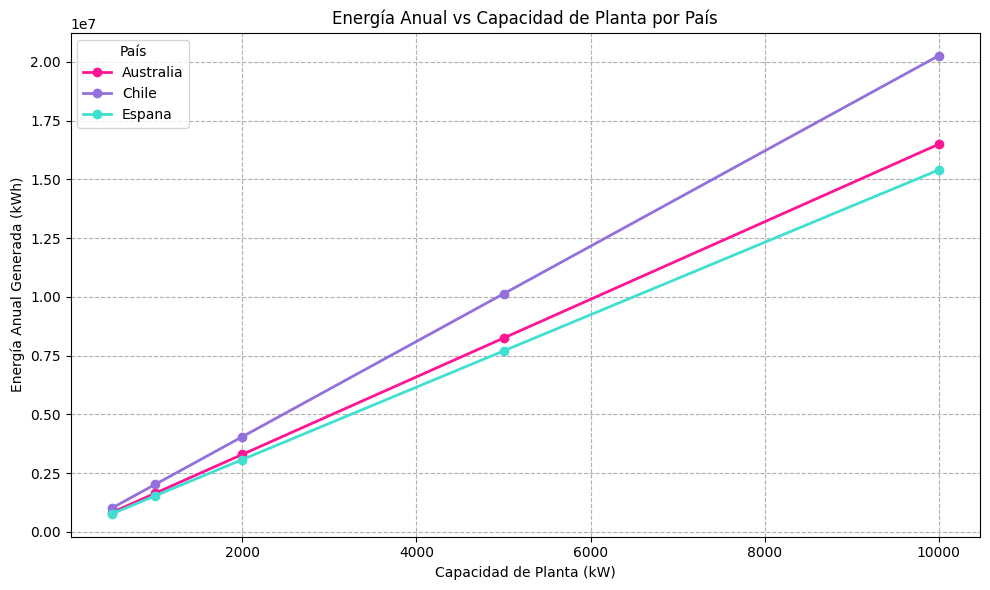


Gráfico comparativo Energía vs Capacidad guardado en: /home/nicole/proyecto/NicoleTorres/PRUEBA1/graficos/simulacion_pv/pv_energia_vs_capacidad_all_countries.png
Resultados numéricos Energía vs Capacidad guardados en: /home/nicole/proyecto/NicoleTorres/PRUEBA1/Resultados/resultados_pv_energia_vs_capacidad.csv


In [28]:
simular_comparativa_energia_capacidad(paises, plantas, output_dir_graphs, output_dir_results)

# 2. Análisis de Sensibilidad de Inclinación (Configuración Fija 1MW)


--- Iniciando Análisis de Sensibilidad de Inclinación ---
  Calculando sensibilidad de inclinación para Australia (Azimuth: 0°)...
  Calculando sensibilidad de inclinación para Chile (Azimuth: 0°)...
  Calculando sensibilidad de inclinación para Espana (Azimuth: 180°)...
---------------------Gráfico de sensibilidad de inclinación-------------------


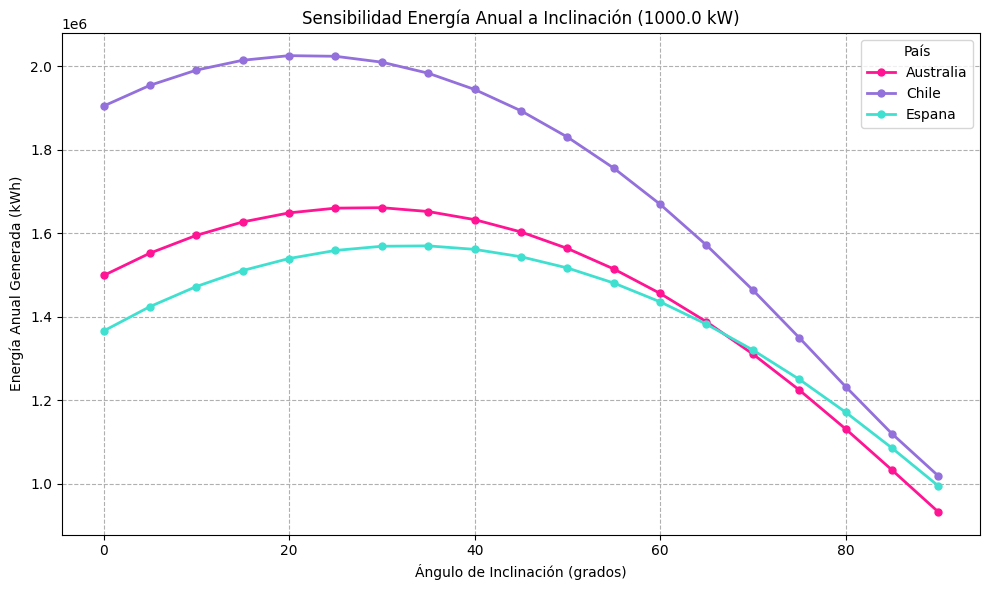


Gráfico de sensibilidad de inclinación guardado en: /home/nicole/proyecto/NicoleTorres/PRUEBA1/graficos/simulacion_pv/tilt_sensitivity_all_countries_1000kW.png
Resultados numéricos Sensibilidad Inclinación guardados en: /home/nicole/proyecto/NicoleTorres/PRUEBA1/Resultados/resultados_pv_sensibilidad_tilt_1000kW.csv


In [29]:
analizar_sensibilidad_inclinacion(paises, output_dir_graphs, output_dir_results,config_sens_tilt)

# 3. Comparación de Azimut (Configuración Fija 1MW, Tilt 20°)


--- Iniciando Comparación de Azimut (0° vs 180°) ---
  Calculando comparación de azimut para Australia...
  Calculando comparación de azimut para Chile...
  Calculando comparación de azimut para Espana...
----------------------------Gráfico de comparación de azimut----------------------------


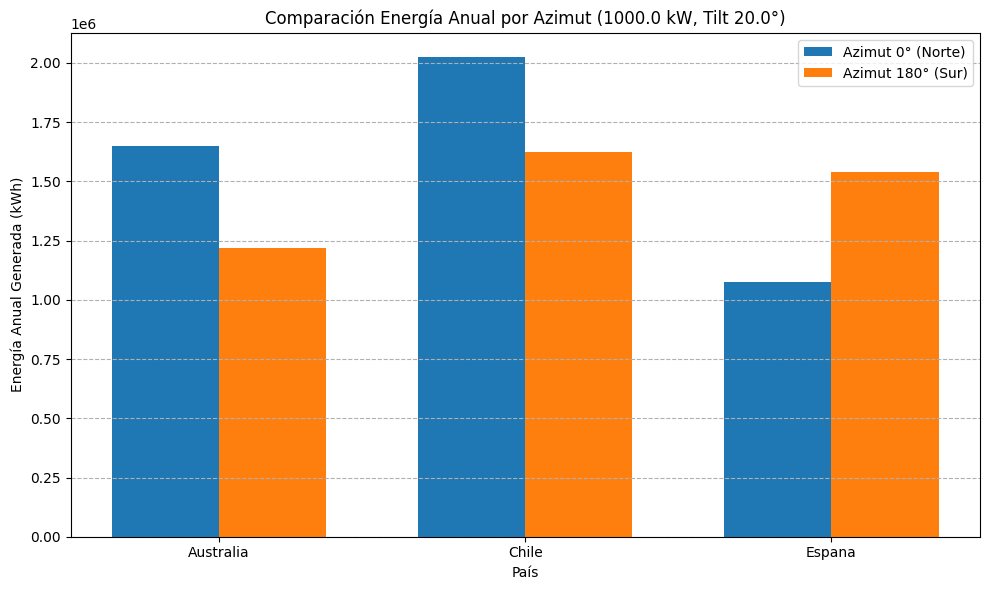


Gráfico de comparación de azimut guardado en: /home/nicole/proyecto/NicoleTorres/PRUEBA1/graficos/simulacion_pv/azimuth_comparison_1000kW_tilt20.png
Resultados numéricos Comparación Azimut guardados en: /home/nicole/proyecto/NicoleTorres/PRUEBA1/Resultados/resultados_pv_comparacion_azimut_1000kW_tilt20.csv


In [30]:
comparar_azimut(paises, output_dir_graphs, output_dir_results, config_azimut)

# 4. Análisis de Sensibilidad del  DC/AC Ratio (Configuración Fija 1MW, Tilt 20°)


--- Iniciando Análisis de Sensibilidad del Ratio DC/AC ---
  Calculando sensibilidad DC/AC para Australia (Azimuth: 0°)...
  Calculando sensibilidad DC/AC para Chile (Azimuth: 0°)...
  Calculando sensibilidad DC/AC para Espana (Azimuth: 180°)...
----------------------------Gráfico de sensibilidad DC/AC----------------------------


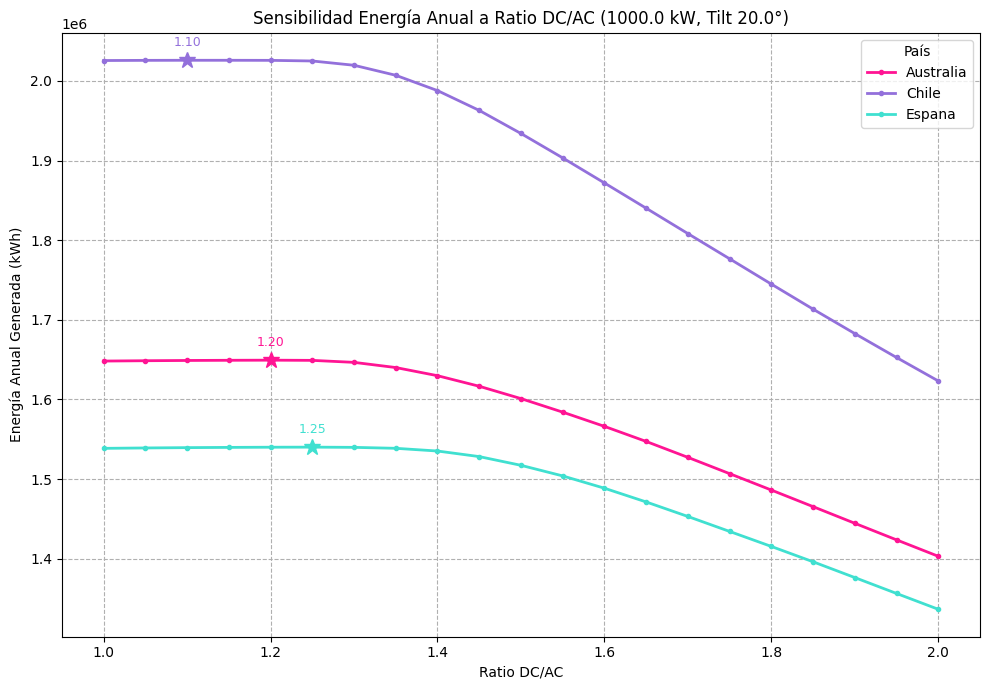


Gráfico de sensibilidad DC/AC guardado en: /home/nicole/proyecto/NicoleTorres/PRUEBA1/graficos/simulacion_pv/dcac_sensitivity_all_countries_1000kW_tilt20.png
Resultados numéricos Sensibilidad DC/AC guardados en: /home/nicole/proyecto/NicoleTorres/PRUEBA1/Resultados/resultados_pv_sensibilidad_dcac_1000kW_tilt20.csv


In [33]:
analizar_sensibilidad_dcac(paises, output_dir_graphs, output_dir_results, config_dcac)

# ANÁLISIS ECONÓMICO

In [37]:
analizar_lcoe_vs_fcr(paises, output_dir_graphs, output_dir_results, config_lcoe_base)


--- Iniciando Análisis LCOE vs FCR ---
  Calculando LCOE vs FCR para Australia...
    Error durante análisis LCOE vs FCR para australia: name 'color_pais' is not defined


NameError: name 'color_pais' is not defined


--- Iniciando Análisis de Sensibilidad del LCOE --- 
  Calculando sensibilidad LCOE para Australia...
    - Sensibilidad a: fixed_charge_rate
    - Sensibilidad a: fixed_operating_cost
    - Sensibilidad a: variable_operating_cost
    - Sensibilidad a: inv_eff
    - Sensibilidad a: capital_cost
  Calculando sensibilidad LCOE para Chile...
    - Sensibilidad a: fixed_charge_rate
    - Sensibilidad a: fixed_operating_cost
    - Sensibilidad a: variable_operating_cost
    - Sensibilidad a: inv_eff
    - Sensibilidad a: capital_cost
  Calculando sensibilidad LCOE para Espana...
    - Sensibilidad a: fixed_charge_rate
    - Sensibilidad a: fixed_operating_cost
    - Sensibilidad a: variable_operating_cost
    - Sensibilidad a: inv_eff
    - Sensibilidad a: capital_cost

  Generando gráficos combinados de sensibilidad LCOE...
    Gráfico LCOE sens vs fixed_charge_rate guardado en: /home/nicole/proyecto/NicoleTorres/PRUEBA1/graficos/simulacion_pv/lcoe_sensitivity_vs_fixed_charge_rate_all_cou

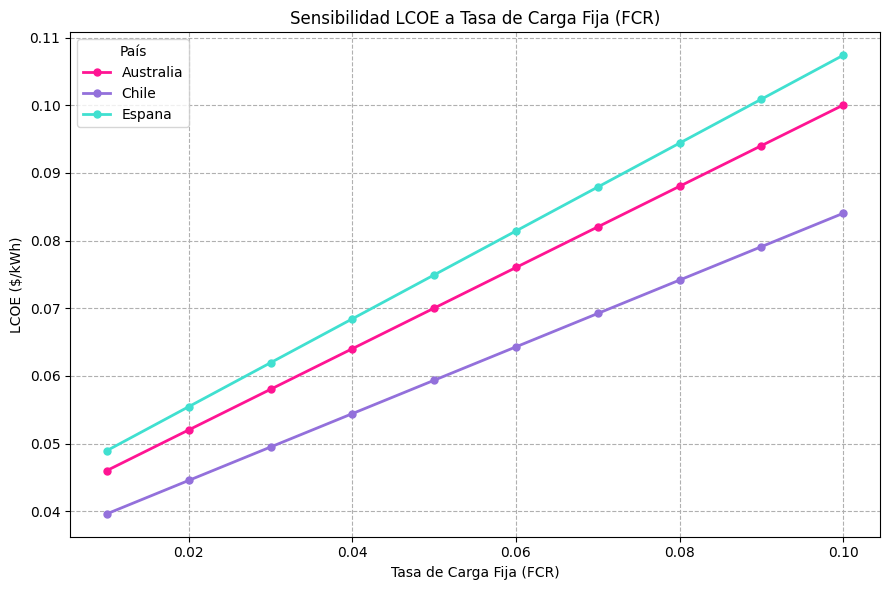

    Gráfico LCOE sens vs fixed_operating_cost guardado en: /home/nicole/proyecto/NicoleTorres/PRUEBA1/graficos/simulacion_pv/lcoe_sensitivity_vs_fixed_operating_cost_all_countries.png


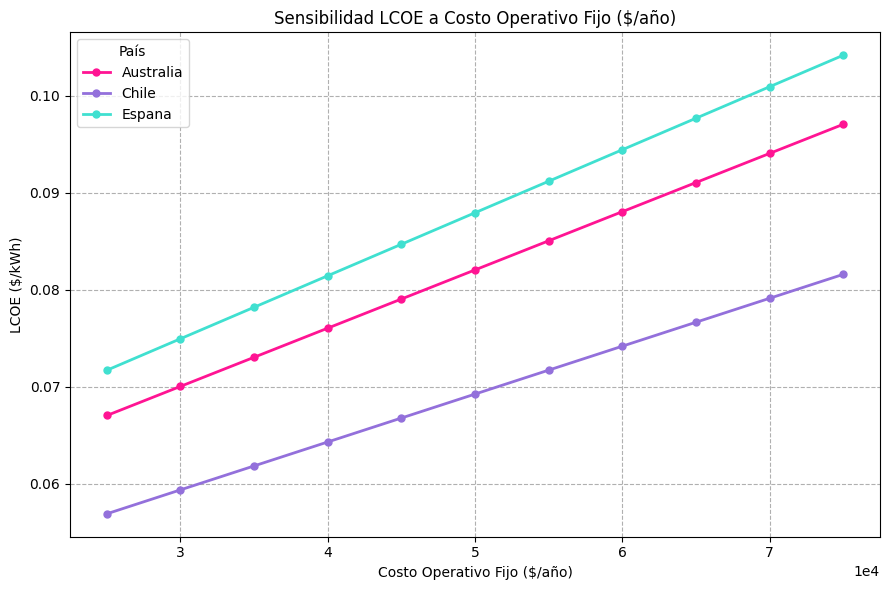

    Gráfico LCOE sens vs variable_operating_cost guardado en: /home/nicole/proyecto/NicoleTorres/PRUEBA1/graficos/simulacion_pv/lcoe_sensitivity_vs_variable_operating_cost_all_countries.png


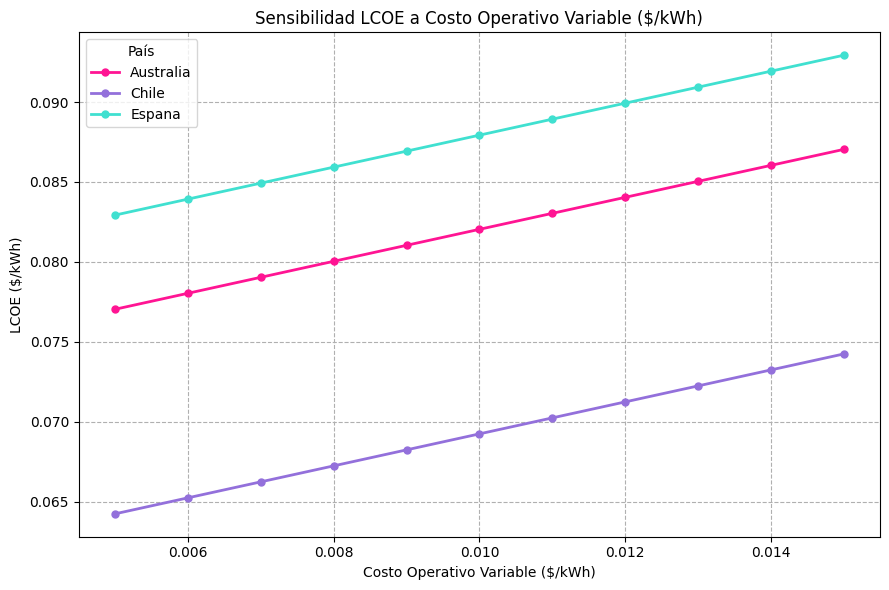

    Gráfico LCOE sens vs inv_eff guardado en: /home/nicole/proyecto/NicoleTorres/PRUEBA1/graficos/simulacion_pv/lcoe_sensitivity_vs_inv_eff_all_countries.png


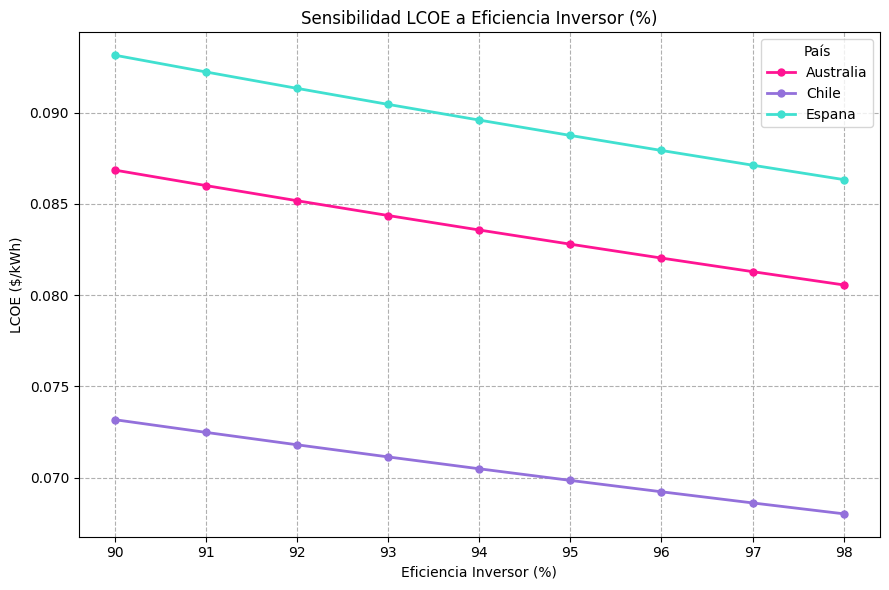

    Gráfico LCOE sens vs capital_cost guardado en: /home/nicole/proyecto/NicoleTorres/PRUEBA1/graficos/simulacion_pv/lcoe_sensitivity_vs_capital_cost_all_countries.png


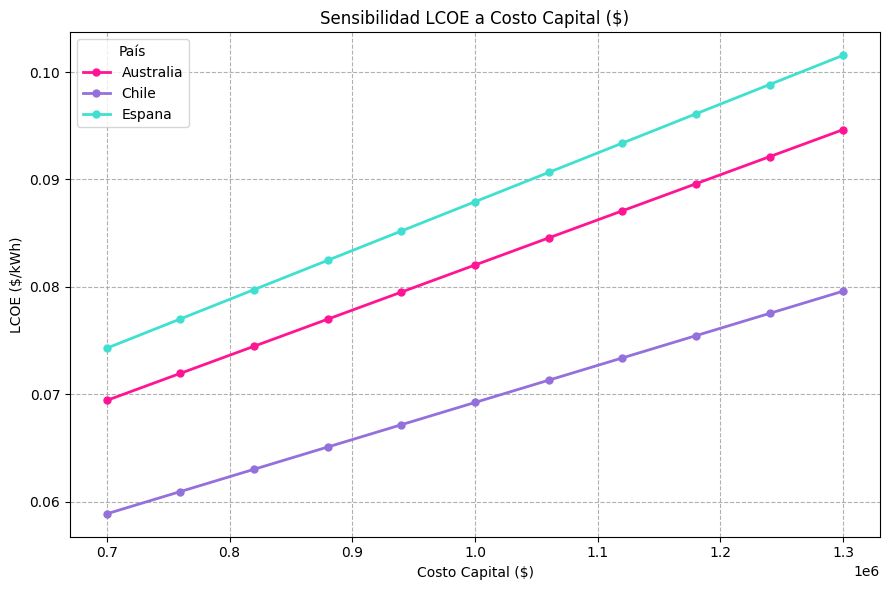

In [55]:
analizar_sensibilidad_lcoe(paises, output_dir_graphs,  config_lcoe_base, lcoe_sens_ranges)